In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
import re

In [2]:
df = pd.read_csv('budgetwise_synthetic_dirty.csv')

Renaming columns correctly for ease of use

In [3]:
df.columns = ['transactionid', 'userid', 'date', 'transactiontype', 'category',
              'amount', 'paymentmode', 'location', 'notes']

Strip leading/trailing whitespace from string columns

In [4]:
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

/tmp/ipython-input-242626680.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Handling multiple date formats

In [5]:
def parse_date_safe(text):
    try:
        return parse(text, dayfirst=True)
    except:
        return pd.NaT

df['date'] = df['date'].apply(parse_date_safe)
print(f"Null dates after parsing: {df['date'].isnull().sum()}")

Null dates after parsing: 344


 Cleaning 'amount' column: extract valid numbers, convert to float

In [6]:
def clean_amount(val):
    if pd.isnull(val):
        return np.nan
    val_str = re.sub(r'[^\d.-]', '', str(val))  # Keep digits, dot, and minus only
    try:
        return float(val_str)
    except:
        return np.nan

df['amount'] = df['amount'].apply(clean_amount)
print(f"Null amounts after cleaning: {df['amount'].isnull().sum()}")

Null amounts after cleaning: 178


Filling missing amounts with 0

In [7]:
df['amount'].fillna(0, inplace=True)

/tmp/ipython-input-2203327895.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['amount'].fillna(0, inplace=True)


 Standardizing categorical columns to lowercase

In [8]:
for col in ['transactiontype', 'category', 'paymentmode', 'location']:
    df[col] = df[col].str.lower().fillna('unknown')

In [9]:
category_fixes = {
    'foood':'food', 'fod':'food', 'entertainmentt':'entertainment', 'utillities':'utilities',
    'savingss':'savings', 'otherss':'others', 'healt':'health', 'travell':'travel'
}
df['category'] = df['category'].replace(category_fixes)
df['transactiontype'] = df['transactiontype'].replace({'expenser':'expense','expensee':'expense','incomee':'income'})

Drop rows missing critical data like date or transactiontype

In [10]:
df.dropna(subset=['date', 'transactiontype'], inplace=True)

Remove duplicate rows

In [11]:
df.drop_duplicates(inplace=True)

Detecting and removing outlier amounts via IQR with some buffer

In [12]:
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

In [13]:
before_rows = df.shape[0]
df = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]
print(f"Removed {before_rows - df.shape[0]} outlier rows based on amount")

Removed 2373 outlier rows based on amount


Summary statistics

In [14]:
print(df.describe(include='all'))

       transactionid userid                           date transactiontype  \
count          12330  12330                          12330           12330   
unique         12205    192                            NaN               2   
top           T14837   U020                            NaN         expense   
freq               3     81                            NaN           12305   
mean             NaN    NaN  2020-12-28 19:06:16.642335744             NaN   
min              NaN    NaN            2019-01-01 00:00:00             NaN   
25%              NaN    NaN            2020-01-01 00:00:00             NaN   
50%              NaN    NaN            2020-12-23 12:00:00             NaN   
75%              NaN    NaN            2021-12-29 00:00:00             NaN   
max              NaN    NaN            2022-12-31 00:00:00             NaN   
std              NaN    NaN                            NaN             NaN   

       category        amount    paymentmode   location  notes 

# Exploratory Data Analysis Visualizations

In [15]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Transaction type counts

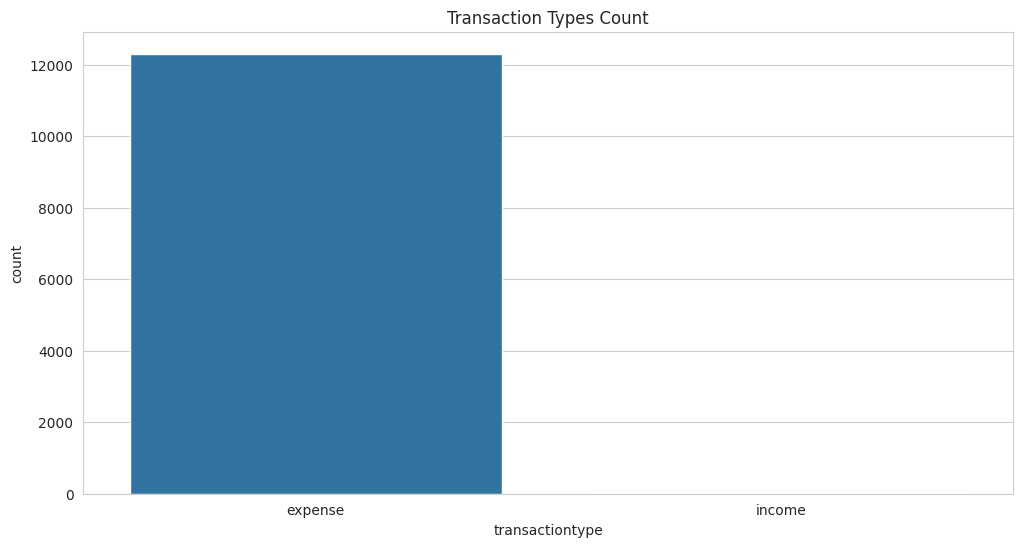

In [16]:
plt.figure()
sns.countplot(x='transactiontype', data=df, order=df['transactiontype'].value_counts().index)
plt.title('Transaction Types Count')
plt.show()

Category distribution (top 15)

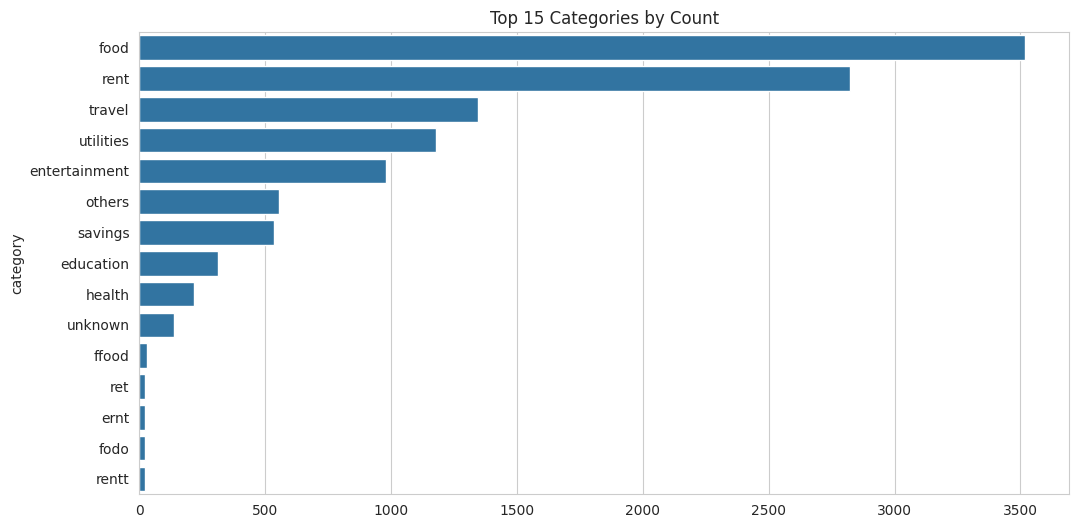

In [17]:
plt.figure()
top_cat = df['category'].value_counts().head(15)
sns.barplot(y=top_cat.index, x=top_cat.values, orient='h')
plt.title('Top 15 Categories by Count')
plt.show()

Amount distribution violin plot by transaction type

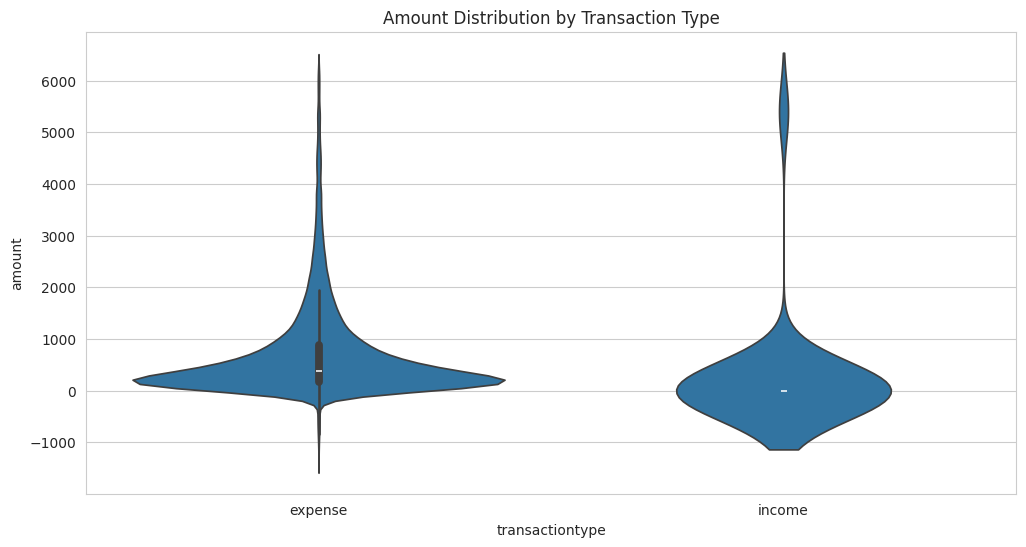

In [18]:
plt.figure()
sns.violinplot(x='transactiontype', y='amount', data=df)
plt.title('Amount Distribution by Transaction Type')
plt.show()

Total amount by category

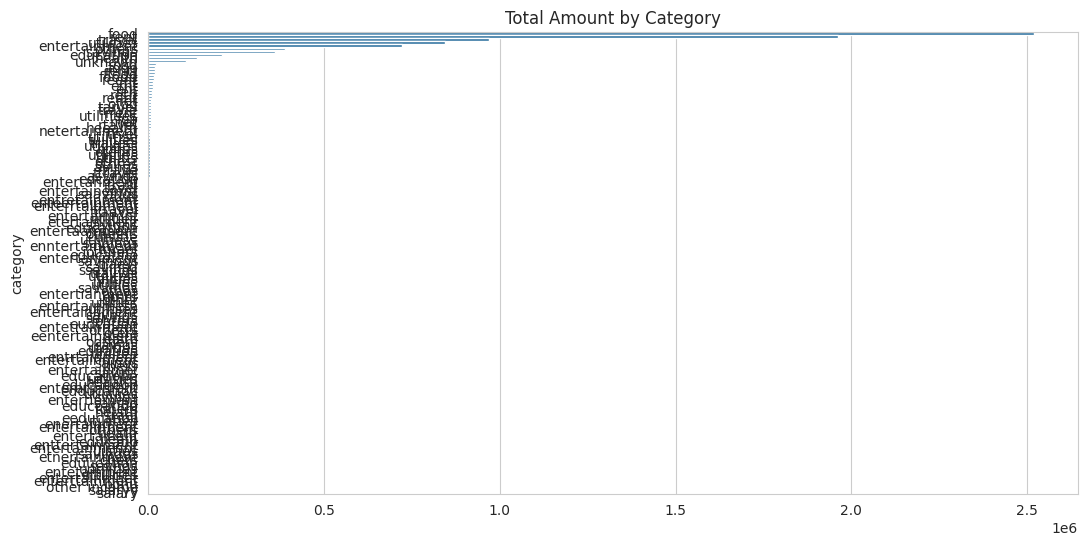

In [19]:
plt.figure()
sum_by_cat = df.groupby('category')['amount'].sum().sort_values(ascending=False)
sns.barplot(x=sum_by_cat.values, y=sum_by_cat.index)
plt.title('Total Amount by Category')
plt.show()

Time series: monthly transaction counts and sums

/tmp/ipython-input-3944308669.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.resample('M').size()
/tmp/ipython-input-3944308669.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sums = df.resample('M')['amount'].sum()


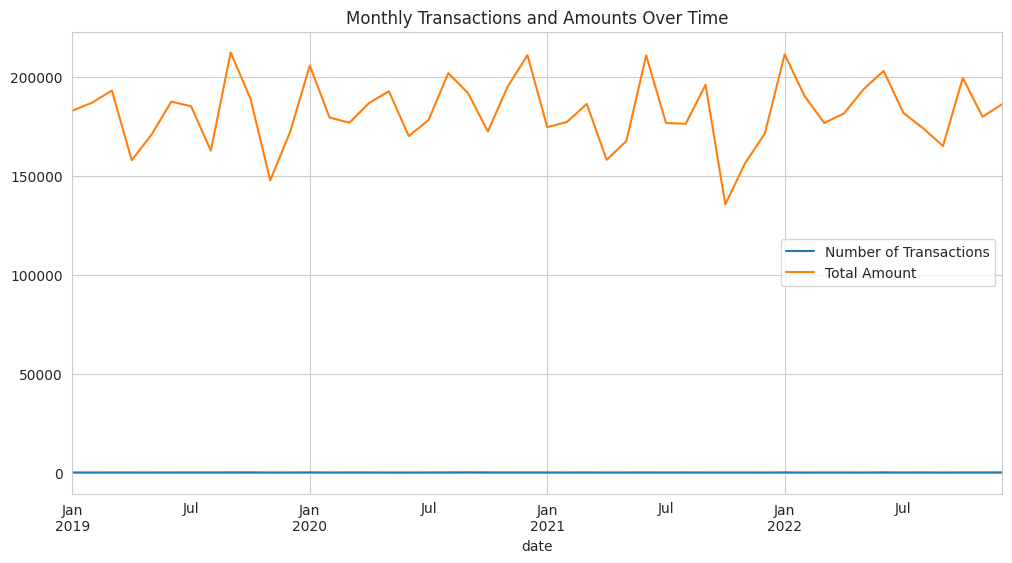

In [20]:
df.set_index('date', inplace=True)
monthly_counts = df.resample('M').size()
monthly_sums = df.resample('M')['amount'].sum()

plt.figure()
monthly_counts.plot(label='Number of Transactions')
monthly_sums.plot(label='Total Amount')
plt.legend()
plt.title('Monthly Transactions and Amounts Over Time')
plt.show()

In [21]:
df.reset_index(inplace=True)

Payment mode counts

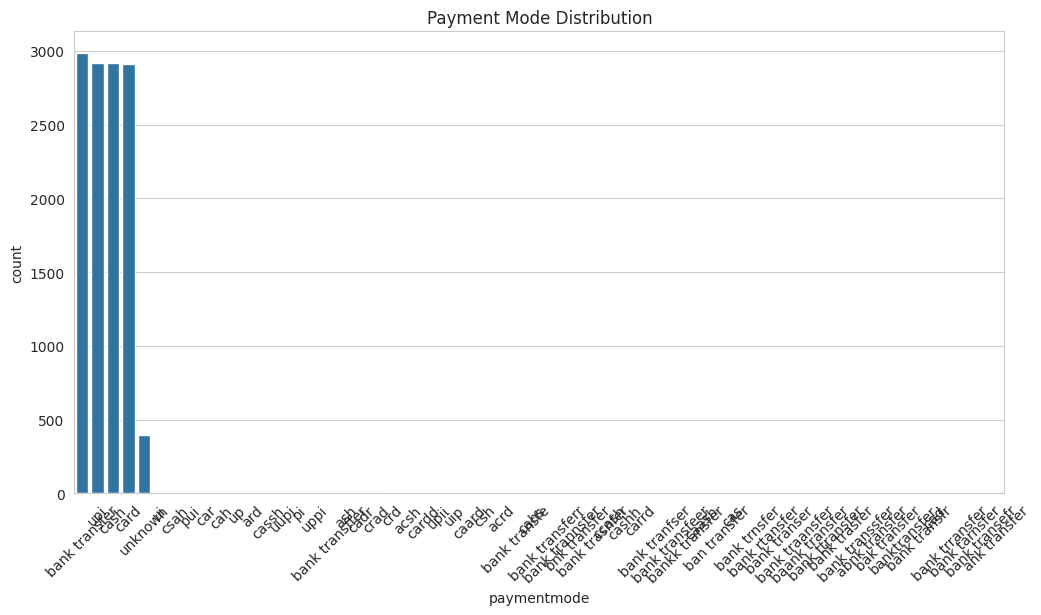

In [22]:
plt.figure()
sns.countplot(x='paymentmode', data=df, order=df['paymentmode'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Payment Mode Distribution')
plt.show()

Location counts (top 20)

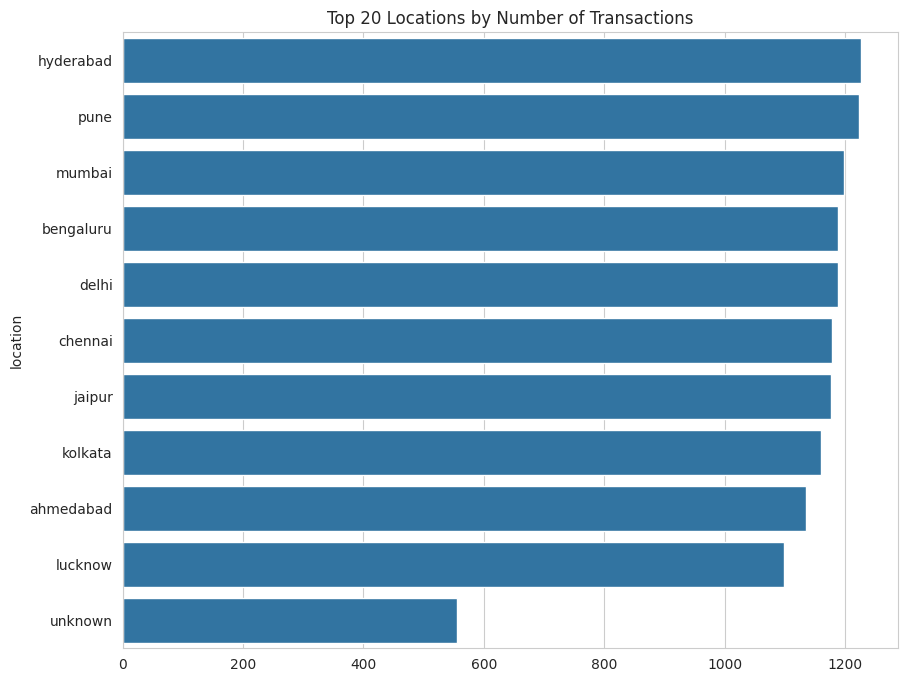

In [23]:
plt.figure(figsize=(10, 8))
top_locs = df['location'].value_counts().head(20)
sns.barplot(y=top_locs.index, x=top_locs.values)
plt.title('Top 20 Locations by Number of Transactions')
plt.show()

Boxplot for amount by category

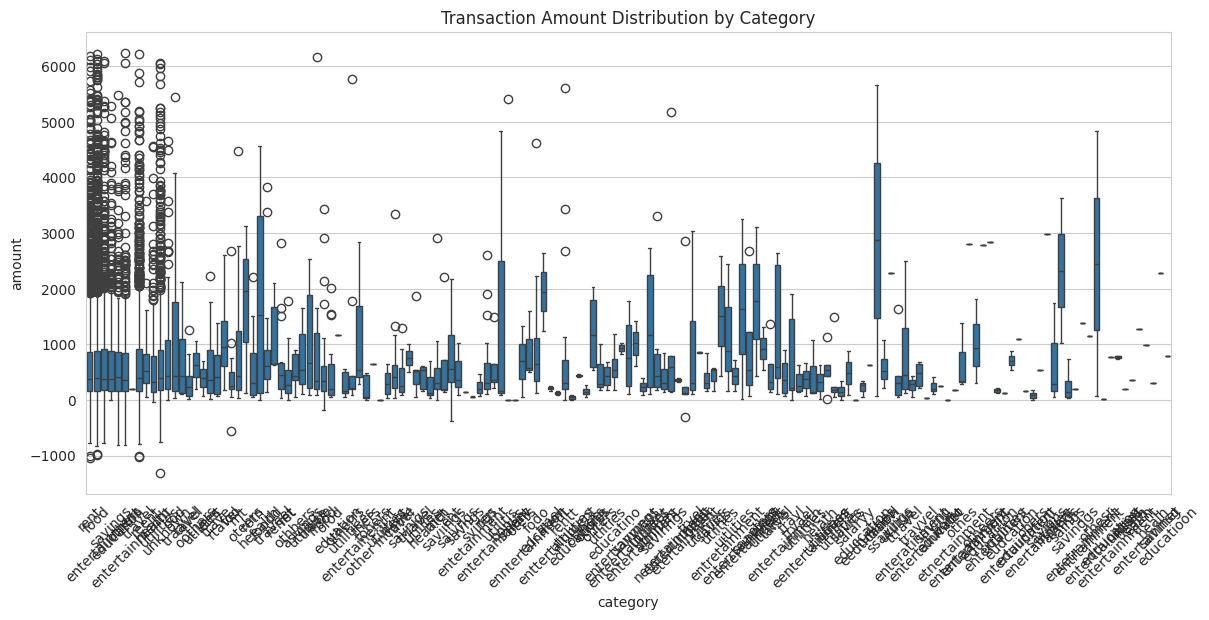

In [24]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x='category', y='amount')
plt.xticks(rotation=45)
plt.title('Transaction Amount Distribution by Category')
plt.show()